# 기본 + 큰 영역 공급유형 반영 + 작은영역 임대상가 추가

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [4]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [5]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [6]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [7]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [8]:
level = 85

In [9]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

[큰 영역]
- 장기전세 공공임대(단기) 공공임대(분납) 공공분양
- 영구임대 행복주택
- 나머지

In [10]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [11]:
train_code = train[train['단지내주차면수']>=987]['단지코드'].values
test_code = test[test['단지내주차면수']>=987]['단지코드'].values

In [12]:
train.loc[(train['공급유형'].isin(['공공임대(단기)', '장기전세','공공임대(분납)','공공분양']))&(train['단지코드'].isin(train_code)), '공급유형'] = '공공임대/분납'
test.loc[(test['공급유형'].isin(['공공임대(단기)', '장기전세','공공임대(분납)','공공분양']))&(test['단지코드'].isin(test_code)), '공급유형'] = '공공임대/분납'

In [13]:
train.loc[(train['공급유형'].isin(['영구임대', '행복주택']))&(train['단지코드'].isin(train_code)), '공급유형'] = '영구/행복'
test.loc[(test['공급유형'].isin(['영구임대', '행복주택']))&(test['단지코드'].isin(test_code)), '공급유형'] = '영구/행복'

- 1차원으로 합치기

In [14]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [15]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

### 6) 임대료 임대보증금 : 평균

In [16]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [17]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [18]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [19]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [20]:
col = ['단지명','도로명주소','subway_name']

In [21]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

### 9) 환승역 수

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [22]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [23]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

- 전용면적별세대수 채우기

In [24]:
for i in train.loc[train['단지코드'].isin(train_code),'공급유형'].unique():
    train_up[i] = 0
    test_up[i] = 0

In [25]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
sample = pd.DataFrame(tmp.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_up[train_up['단지코드']==code].index
    train_up.loc[ind,col] = val
train_up = train_up.fillna(0)

In [26]:
tmp = test[test['단지내주차면수']>=987].reset_index(drop=True)
sample = pd.DataFrame(tmp.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_up[test_up['단지코드']==code].index
    test_up.loc[ind,col] = val
test_up = test_up.fillna(0)

In [27]:
for i in train.loc[-train['단지코드'].isin(train_code),'공급유형'].unique():
    train_down[i] = 0
    test_down[i] = 0

In [28]:
tmp = train[train['단지내주차면수']<987].reset_index(drop=True)
sample = pd.DataFrame(tmp.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_down[train_down['단지코드']==code].index
    train_down.loc[ind,col] = val
train_down = train_down.fillna(0)
#train_down = train_down.drop('임대상가',axis=1)

In [29]:
tmp = test[test['단지내주차면수']<987].reset_index(drop=True)
sample = pd.DataFrame(tmp.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_down[test_down['단지코드']==code].index
    test_down.loc[ind,col] = val
test_down = test_down.fillna(0)
#test_down = test_down.drop('임대상가',axis=1)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [30]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

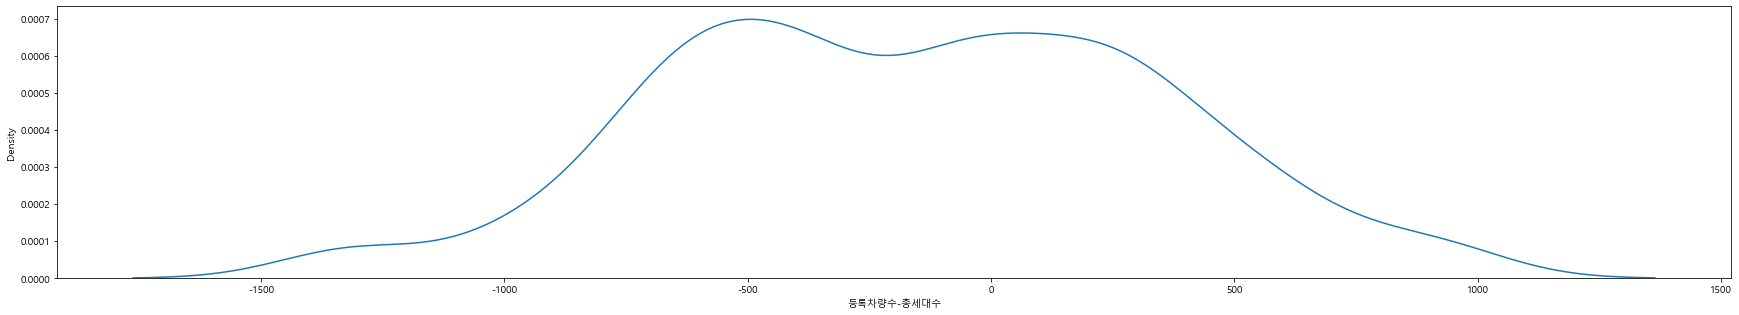

In [31]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

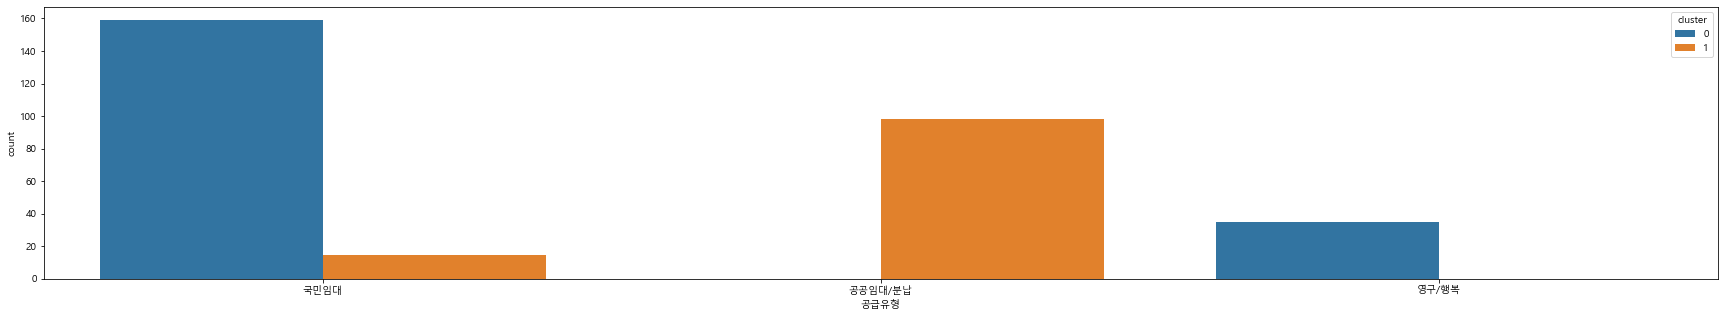

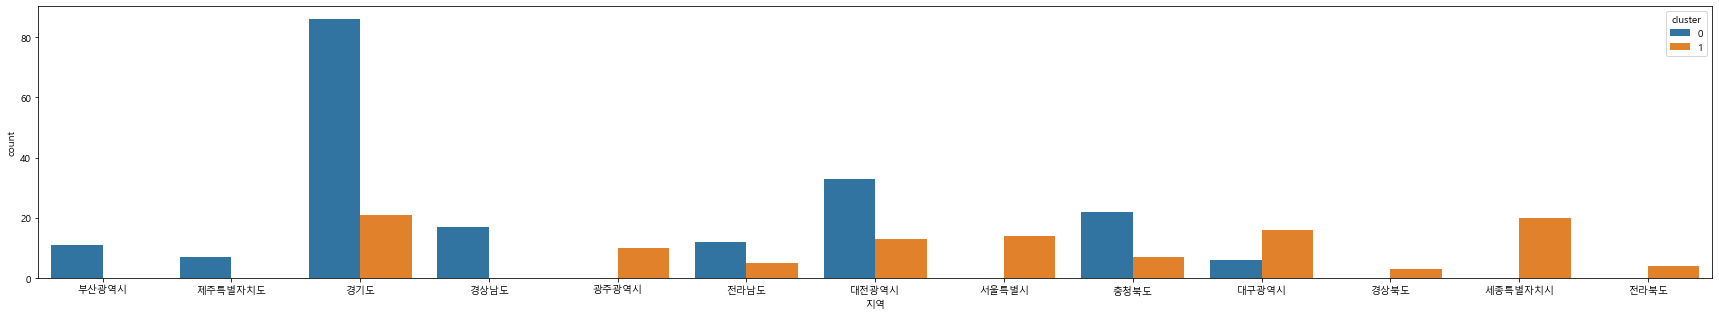

In [32]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

- 장기전세 공공임대(단기) 공공임대(분납) 공공분양
- 영구임대 행복주택
- 나머지

In [33]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [34]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [35]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [37]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [38]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [39]:
models = [CatBoostRegressor(random_state=2021)]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  106.06842314549127


### 2) train/test up

In [40]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021)]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  290.76626212749295


## 4. Final prediction

In [41]:
train_down.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적',
       '위도', '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율',
       '임대료', '임대보증금', '대형전용면적', '국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)',
       '공공임대(분납)', '장기전세', '행복주택', '임대상가'],
      dtype='object')

In [42]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율','국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)',
       '공공임대(분납)', '장기전세', '행복주택', '임대상가', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [43]:
X_train = train_down.drop(columns=['단지코드','등록차량수','환승역 수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드','환승역 수'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [44]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

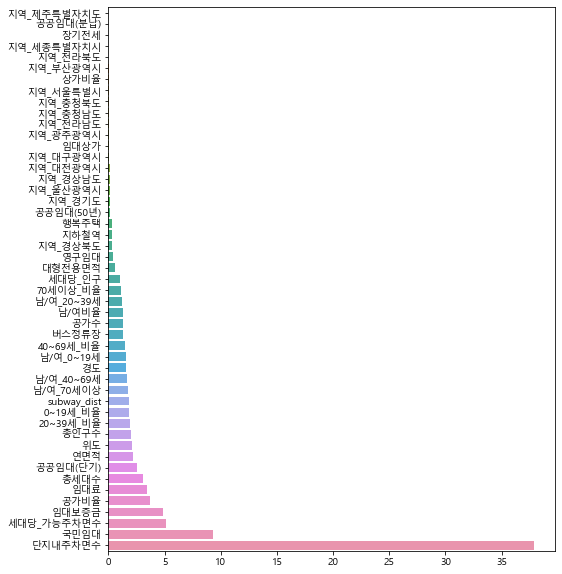

In [46]:
plt.figure(figsize=(8,10))
sns.barplot(y = X_train.columns[np.argsort(cb_down.feature_importances_)], x = list(cb_down.feature_importances_[np.argsort(cb_down.feature_importances_)]))

In [47]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '공공임대/분납', '영구/행복'
       , '임대료','임대보증금', '대형전용면적']

In [48]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율','환승역 수'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역','상가비율','환승역 수'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

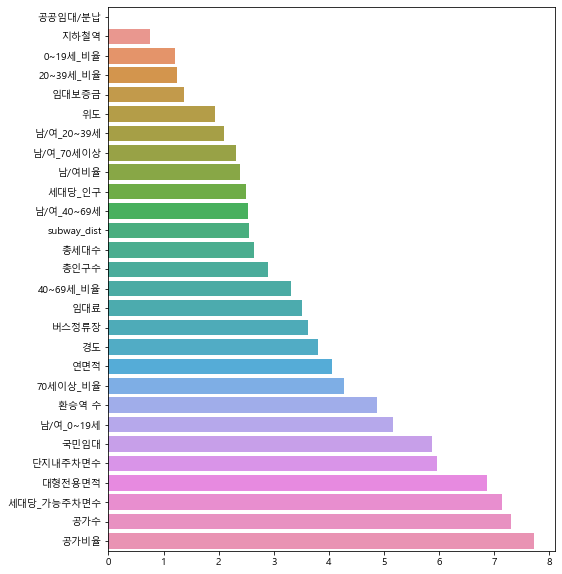

In [49]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(cb_up.feature_importances_)], x = list(cb_up.feature_importances_[np.argsort(cb_up.feature_importances_)]))

In [50]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

## 5. 기존 score와 비교 및 제출

In [51]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [52]:
sub = submit()
sub.to_csv("result/0721_1.csv",index=False)

In [53]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [54]:
res2 = score(96)

전체 MAE :  20.29942218727599
큰 영역 MAE :  50.506705603887795
작은 영역 MAE :  15.815528555122672


In [55]:
res1 = score(98)

전체 MAE :  21.000862553358264
큰 영역 MAE :  55.93363896252437
작은 영역 MAE :  15.815528555122668


In [56]:
res3 = score(99)

전체 MAE :  42.28465239290399
큰 영역 MAE :  121.56263248614792
작은 영역 MAE :  30.5168272228131


In [57]:
res4 = score(100)

전체 MAE :  44.38299562027108
큰 영역 MAE :  117.30796987811073
작은 영역 MAE :  33.55819475387301


In [58]:
tmp = pd.merge(res1,res2[['code','num_x']],on='code')
tmp.columns = ['code','98','current','96']
val = test_up['단지코드'].values
tmp.loc[tmp['code'].isin(val),:]

,code,98,current,96
1,C1128,1233.521669,1197.751340,1188.382634
4,C1332,1242.048005,1326.494108,1327.919226
5,C1563,1748.191625,1697.594538,1797.687836
6,C1794,1001.720950,964.807481,1048.372040
30,C1152,834.637799,874.113574,847.316183
45,C2555,1440.029494,1380.225477,1440.366369
52,C2608,1097.537303,1081.537814,1193.936851
67,C1617,1050.294315,1098.418873,1067.296112
74,C1250,1199.897823,1305.123286,1205.940954
80,C2028,1229.713242,1035.514244,1060.469848
